In [1]:
"""File for regression analysis and capturing district features"""


import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import collections
import pandas as pd


class ChicagoCrime:
    def __init__(self, data):
        self.districts = []
        self.df = data
        self.best_models = []

    def create_districts(self):
        districts = self.df.District.unique()
        for d in districts:
            d_name = "District" + str(int(d))
            d_data = self.df.loc[self.df.District == d, :]
            new_district = DistrictCrime(d_name, d_data)
            self.districts.append(new_district)

    def generate_best_models(self, model_type=None, print_items=False):
        for district in self.districts:
            model_names, model_mse, model_pred, model_features = district.model_report(model_type)
            model_rank = sorted([(n, m, f, p) for n, m, f, p in zip(model_names, model_mse,
                                                                    model_features, model_pred)], key=lambda x: x[1])
            if print_items:
                print(district.name)
                print("- Model: {} - mse: {}".format(model_rank[0][0], model_rank[0][1]), max(model_mse))
            self.best_models.append([district, model_rank[0]])

In [2]:
class DistrictCrime:
    def __init__(self, name, data):
        self.name = name
        self.data = data
        self.daily_crime = data.groupby(['NormalizedDate']).ID.count()
        self.dates = self.daily_crime.index
        # Properties for Later
        self.day_average = None
        self.day_average_days = None
        self.detrended = None
        self.normalized_detrended = None
        self.anomaly_index = None
        # Feature Properties
        self.crime_features = None
        self.true_crime = None
        self.model_dates = None
        self.days_of_past_crime = None
        # Model Input
        self.X_train = None
        self.Y_train = None
        self.train_date = None
        self.X_test = None
        self.Y_test = None
        self.test_date = None
        self.district_models = []

    def n_day_average(self, days):
        """Sets properties that contain a n-day average and how much n is"""
        day_average = [np.mean(self.daily_crime[i-days: i]) for i in range(len(self.daily_crime)) if i > days-1]
        self.day_average = day_average
        self.day_average_days = days
        self.detrend_crime()
        self.set_anomalies(self.detrended)
        
    def detrend_crime(self):
        """Set the detrended variable"""
        detrended = [actual - trend for actual, trend in zip(self.daily_crime[self.day_average_days:], self.day_average)]
        self.detrended = detrended

    # Anomaly Section
    @staticmethod
    def locate_anomalies(my_series, g_threshold, l_threshold):
        items_greater = [i for i in range(len(my_series)) if my_series[i] > g_threshold]
        items_less = [i for i in range(len(my_series)) if my_series[i] < l_threshold]
        return set(items_greater + items_less)

    def set_anomalies(self, values):
        iteration = 0
        mean = np.mean(values)
        std = np.std(values)
        g_threshold = mean + 3 * std
        l_threshold = mean - 3 * std
        anoms = self.locate_anomalies(values, g_threshold, l_threshold)
        prev_anoms = set()
        anom_iteration = list()
        while len(anoms) > len(prev_anoms):
            anom_iteration.append(anoms)
            prev_anoms = anoms
            iteration += 1
            new_values = [v for i, v in enumerate(values) if i not in anoms]
            mean = np.mean(new_values)
            std = np.std(new_values)
            g_threshold = mean + 3 * std
            l_threshold = mean - 3 * std
            anoms = self.locate_anomalies(values, g_threshold, l_threshold)
        self.anomaly_index = anoms

    def min_max_scaler(self, fields, col_min, col_max):
        fields_new = [(r - col_min) / (col_max - col_min) for r in fields]
        return fields_new
        
    # Get Crime Features
    def generate_features(self, num_fea):
        """On detrended series, create a table such that for each day, the previous k day values are in the row."""
        # crime_features = [self.detrended[i - num_fea:i] for i in range(len(self.detrended)) if i >= num_fea]
        crime_true = [self.detrended[i] for i in range(len(self.detrended)) if i >= num_fea]
        crime_date = [d for i, d in enumerate(self.dates[self.day_average_days:]) if i >= num_fea]
        self.true_crime = crime_true
        self.model_dates = crime_date
        self.days_of_past_crime = num_fea
        crime_dict = {'NormalizedDate': pd.Series(crime_date, index=crime_date)}
        for i in range(1, num_fea+1):
            col_name = str(i) + "DaysAgo"
            crime_dict[col_name] = pd.Series(list(self.detrended)[num_fea - i : -i], index=crime_date)
        self.crime_features = pd.DataFrame(crime_dict, index=crime_date)
        self.normalize_crime()
        
    def normalize_crime(self):
        """Normalize the crime columns with the standard deviation, as detrended mean should alreaddy be ~zero"""
        fea_std = self.crime_features.loc[:, self.crime_features.columns != 'NormalizedDate'].values.std()
        for c in self.crime_features.columns:
            if c != 'NormalizedDate':
                self.crime_features[c] = self.crime_features[c] / fea_std

    def split_data(self, test_size):
        # Train Data
        self.X_train = self.crime_features.iloc[0:-test_size, self.crime_features.columns != 'NormalizedDate']
        self.Y_train = self.true_crime[0:-test_size]
        self.train_date = self.model_dates[0:-test_size]
        # Test Data
        self.X_test = self.crime_features.iloc[-test_size:, self.crime_features.columns != 'NormalizedDate']
        self.Y_test = self.true_crime[-test_size:]
        self.test_date = self.model_dates[-test_size:]

    # Additional Features
    def holiday_feature(self, holiday_only=True, type_exclude=None, past_n_days=False):
        """Create features related to if the date is a holiday"""
        holiday_file = r'..\Holidays.csv'
        holiday_df = pd.read_csv(holiday_file, parse_dates=['HolidayDate'])
        if past_n_days:
            dates_to_check = set(holiday_df.loc[holiday_df.Type != type_exclude, 'HolidayDate'])
            self.crime_features['IsHoliday'] = self.crime_features.NormalizedDate.apply(lambda x: x in dates_to_check)
            self.crime_features['HolidayPastDays'] = [np.sum(self.crime_features.IsHoliday[max(0, i-past_n_days):i]) 
                                                    for i, x in enumerate(self.crime_features.IsHoliday)]
        elif holiday_only:
            dates_to_check = set(holiday_df.loc[holiday_df.Type != type_exclude, 'HolidayDate'])
            self.crime_features['IsHoliday'] = self.crime_features.NormalizedDate.apply(lambda x: x in dates_to_check)            
        if not holiday_only:
            # Column for each Holiday
            self.crime_features = self.crime_features.merge(holiday_df, how='left',
                                                            left_on='NormalizedDate', right_on='HolidayDate')
            del self.crime_features['HolidayDate']
            del self.crime_features['Type']
            if past_n_days:
                del self.crime_features['IsHoliday']
            self.crime_features = pd.get_dummies(self.crime_features, columns=['Holiday'])

    def date_features(self):
        """Add features related to the date and normalize them"""
        self.crime_features['weekday'] = self.crime_features.NormalizedDate.dt.weekday / 6.0
        self.crime_features['weekNumber'] = self.crime_features.NormalizedDate.dt.week / 53.0
        
    def movie_feature(self):
        """Add Feature of the number of movies released in theaters that week"""
        movie_df = pickle.load(open('ReleasedMovies.pkl', 'rb'))
        movie_df['Year_Week'] = [(y, w) for y, w in zip(movie_df.ReleaseDate.dt.year, movie_df.ReleaseDate.dt.week)]
        movie_counts = movie_df.groupby(['Year_Week']).ReleasedMovie.count()
        grouped_movie = pd.DataFrame({'Year_Week': list(movie_counts.index), 'MovieCount': list(movie_counts)},
                                     index=range(len(movie_counts)))
        self.crime_features['Year_Week'] = [(y, w) for y, w in zip(self.crime_features.NormalizedDate.dt.year,
                                                                   self.crime_features.NormalizedDate.dt.week)]
        self.crime_features = self.crime_features.merge(grouped_movie, how='left', on='Year_Week').fillna(0)
        del self.crime_features['Year_Week']
        # Normalize the Count
        self.crime_features['MovieCount'] = self.crime_features['MovieCount'] / 7.0
        
    def weather_feature(self):
        weather_df = pd.read_csv(r'..\WeatherData.csv', parse_dates=['Date'])
        weather_df['Precipitation'] = weather_df.Precipitation.fillna(0)
        weather_df['NewSnow'] = weather_df.NewSnow.fillna(0)
        weather_df['Avg'] = self.min_max_scaler(weather_df.Avg, weather_df.Avg.min(), weather_df.Avg.max())
        weather_df['Precipitation'] = self.min_max_scaler(weather_df.Precipitation,
                                                          weather_df.Precipitation.min(), weather_df.Precipitation.max())
        weather_df['NewSnow'] = self.min_max_scaler(weather_df.NewSnow, weather_df.NewSnow.min(), weather_df.NewSnow.max())
        self.crime_features = self.crime_features.merge(weather_df.loc[:,['Date', 'Avg', 'NewSnow', 'Precipitation']], 
                                                        how='left', left_on='NormalizedDate', right_on='Date')
        del self.crime_features['Date']

    def model_report(self, model_type=None):
        """Return values related to the best models in each model"""
        model_names = []
        model_mse = []
        model_pred = []
        model_features = []
        for m in self.district_models:
            if model_type is not None and m.Type not in model_type:
                pass
            model_names.append(m.name)
            model_mse.append(m.best_mse)
            if m.best_feature is not None:
                model_pred.append(m.features[m.best_feature]['test_prediction'])
                fea_imp = [(k, v) for k, v in zip(m.features[m.best_feature]['features'],
                                                  m.features[m.best_feature]['feature_importance'])]
                model_features.append(fea_imp)
            else:
                model_pred.append(m.features['test_prediction'])
                model_features.append([('feature', m.features['feature_importance'])])
        return model_names, model_mse, model_pred, model_features
    
    def keep_top_models(self, num_models):
        """Based on the MSE score - keep only the top n models"""
        model_names, model_mse, model_pred, model_features = self.model_report(None)
        model_rank = sorted([(n, m, f, p) for n, m, f, p in zip(model_names, model_mse, model_features, model_pred)],
                            key=lambda x: x[1])
        mse_filter = model_rank[num_models - 1][1]
        model_copy = self.district_models.copy()
        for m in model_copy:
            if m.best_mse > mse_filter:
                self.district_models.remove(m)

    # Plots
    def plot_day_average(self):
        """Plot the day average for a district"""
        plt.figure(figsize=(18, 10))
        plt.plot(self.dates[self.day_average_days:], self.day_average, label=self.name)
        plt.title("{} Day Average in Crime Across {}".format(self.day_average_days, self.name))
        plt.show()

    def plot_detrended(self, show_anomalies=True):
        """Plot the detrended data with anomalies if desired"""
        plt.figure(figsize=(18, 10))
        plt.plot(self.dates[self.day_average_days:], self.detrended, label=self.name)
        if show_anomalies:
            anom_dates = [d for i, d in enumerate(self.dates[self.day_average_days:]) if i in self.anomaly_index]
            anom_vals = [d for i, d in enumerate(self.detrended) if i in self.anomaly_index]
            plt.scatter(anom_dates, anom_vals, c='red')
        plt.legend()
        plt.show()

In [3]:
class DistrictModel:
    def __init__(self, name, model, model_type, X_train, Y_train, X_test, Y_test, max_days):
        self.model = model
        self.name = name
        self.model_type = model_type
        self.features = collections.defaultdict(dict)
        # Model parameters
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.max_crime_days = max_days
        # Note for Best model
        self.best_mse = None
        self.best_feature = None

    def svr_model(self, crime_days, X_train, X_test):
        """Features of a LinearSVR model"""
        self.model.fit(X_train, self.Y_train)
        test_prediction = self.model.predict(X_test)
        test_prediction = [round(x, 0) for x in test_prediction]
        self.features[crime_days]['test_prediction'] = test_prediction
        self.features[crime_days]['feature_importance'] = self.model.coef_
        self.features[crime_days]['features'] = X_train.columns
        self.features[crime_days]['mse'] = mean_squared_error(self.Y_test, test_prediction)
        
    def tree_model(self, crime_days, X_train, X_test):
        """Features of a tree ensemble model"""
        self.model.fit(X_train, [int(x*1000) for x in self.Y_train])
        test_prediction = self.model.predict(X_test)
        test_prediction = [round(x/1000, 0) for x in test_prediction]
        self.features[crime_days]['test_prediction'] = test_prediction
        self.features[crime_days]['feature_importance'] = self.model.feature_importances_
        self.features[crime_days]['features'] = X_train.columns
        self.features[crime_days]['mse'] = mean_squared_error(self.Y_test, test_prediction)

    def linear_model(self, crime_days, X_train, X_test):
        """Generate a linear Model"""
        self.model.fit(X_train, self.Y_train)
        test_prediction = self.model.predict(X_test)
        test_prediction = [round(x, 0) for x in test_prediction]
        self.features[crime_days]['y_intercept'] = self.model.intercept_
        self.features[crime_days]['test_prediction'] = test_prediction
        self.features[crime_days]['feature_importance'] = self.model.coef_
        self.features[crime_days]['features'] = X_train.columns
        self.features[crime_days]['mse'] = mean_squared_error(self.Y_test, test_prediction)

    def generate_linear_models(self):
        """Generate a model for each combination of crime days"""
        X_train = self.X_train.copy()
        X_test = self.X_test.copy()
        # Work backwards from max_crime_days
        for i in range(self.max_crime_days, 1, -1):
            if self.model_type == 'Linear':
                self.linear_model(i, X_train, X_test)
            elif self.model_type == 'Tree':
                self.tree_model(i, X_train, X_test)
            elif self.model_type == 'SVR':
                self.svr_model(i, X_train, X_test)
            col_name = str(i) + "DaysAgo"
            del X_train[col_name]
            del X_test[col_name]
        self.best_model()

    def simplest_model(self):
        train_average = round(np.mean(self.Y_train), 0)
        test_prediction = [train_average for x in self.X_test.iloc[:, 0]]
        test_prediction = [round(x, 0) for x in test_prediction]
        self.features['test_prediction'] = test_prediction
        self.features['feature_importance'] = train_average
        model_mse = mean_squared_error(self.Y_test, test_prediction)
        self.features['mse'] = model_mse
        self.best_mse = model_mse

    def basic_average(self):
        for i in range(self.max_crime_days, 0, -1):
            test_prediction = np.mean(self.X_test.iloc[:, 0:i], axis=1)
            test_prediction = [round(x, 0) for x in test_prediction]
            self.features[i]['test_prediction'] = test_prediction
            self.features[i]['feature_importance'] = [1] * i
            self.features[i]['features'] = self.X_test.columns[0:i]
            self.features[i]['mse'] = mean_squared_error(self.Y_test, test_prediction)
        self.best_model()

    def best_model(self):
        for k, v in self.features.items():
            if self.best_mse is None or v['mse'] < self.best_mse:
                self.best_mse = v['mse']
                self.best_feature = k
    
    def clear_model(self):
        """Free some memory"""
        self.model = None


if __name__ == '__main__':
    pass

In [4]:
import pickle
import os
from sklearn.linear_model import LinearRegression

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVR

In [6]:
def retrieve_data(model_file):
    """Runs the main project"""
    #file_directory = os.path.dirname(os.path.abspath(__file__))
    #model_file = os.path.join(file_directory, dataframe_file)
    if os.path.exists(model_file):
        df = pickle.load(open(model_file, 'rb'))
    else:
        df = load_data()
        df = format_dataframe(df)
        save_df(df, dataframe_file)
    return df

In [7]:
def model_create_add(district, model_name, model, model_type, features=30):
    district_model = DistrictModel(model_name, model, model_type,
                               district.X_train, district.Y_train,
                               district.X_test, district.Y_test, features)
    district_model.generate_linear_models()
    district.district_models.append(district_model)
    district_model.clear_model()

In [8]:
def model_combos(district, model, model_type, basics=False, day_avg=30):
    # reg = LinearRegression()
    # tree = ExtraTreesClassifier(n_estimators=50, criterion='entropy', random_state=42)
    # svr = LinearSVR(random_state=42, max_iter=1000, fit_intercept=False, loss='squared_epsilon_insensitive', dual=False)
    district.n_day_average(day_avg)
    district.generate_features(30)
    ### Linear Only
    district.split_data(180)
    model_create_add(district, model_type + ' - Past Days only', model, model_type, 30)
    ### Simple Model
    if basics:
        district_model = DistrictModel('Simplest Model', model, model_type,
                                   district.X_train, district.Y_train,
                                   district.X_test, district.Y_test, 30)
        district_model.simplest_model()
        district.district_models.append(district_model)    
    ### Add Holiday Flag
    district.holiday_feature(True)
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday W/ Movie', model, model_type, 30)
    ### Add Dates
    district.generate_features(30)
    district.holiday_feature(True)
    district.date_features()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Dates', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Dates Movie', model, model_type, 30)
    ### Reset with each Holiday separate
    district.generate_features(30)
    district.holiday_feature(False)
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Movie', model, model_type, 30)
    ### Add Date Features
    district.generate_features(30)
    district.holiday_feature(False)
    district.date_features()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Dates', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Dates Movie', model, model_type, 30)


In [9]:
def model_past_test(district, model, model_type, day_avg=30):
    # reg = LinearRegression()
    district.n_day_average(day_avg)
    district.generate_features(30)
    ### Add Holiday Flag
    district.holiday_feature(True, None, 4)
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Past', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Movie Past', model, model_type, 30)
    ### Add Dates
    district.generate_features(30)
    district.holiday_feature(True, None, 4)
    district.date_features()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Dates Past', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Dates Movie Past', model, model_type, 30)
    ### Reset with each Holiday separate
    district.generate_features(30)
    district.holiday_feature(False, None, 4)
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Past', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Movie Past', model, model_type, 30)
    ### Add Date Features
    district.generate_features(30)
    district.holiday_feature(False, None, 4)
    district.date_features()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Dates Past', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Dates Movie Past', model, model_type, 30)


In [10]:
def model_weather_test(district, model, model_type, day_avg=30):
    # reg = LinearRegression()
    district.n_day_average(day_avg)
    district.generate_features(30)
    ### Add Holiday Flag
    district.holiday_feature(True, None)
    district.weather_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Weather', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Movie Weather', model, model_type, 30)
    ### Add Dates
    district.generate_features(30)
    district.holiday_feature(True, None)
    district.date_features()
    district.weather_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Dates Weather', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Dates Movie Weather', model, model_type, 30)
    ### Reset with each Holiday separate
    district.generate_features(30)
    district.holiday_feature(False, None)
    district.weather_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Weather', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Movie Weather', model, model_type, 30)
    ### Add Date Features
    district.generate_features(30)
    district.holiday_feature(False, None)
    district.date_features()
    district.weather_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Dates Weather', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Dates Movie Weather', model, model_type, 30)


In [11]:
def model_past_weather_test(district, model, model_type, day_avg=30):
    # reg = LinearRegression()
    district.n_day_average(day_avg)
    district.generate_features(30)
    ### Add Holiday Flag
    district.holiday_feature(True, None, 4)
    district.weather_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Past Weather', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Movie Past Weather', model, model_type, 30)
    ### Add Dates
    district.generate_features(30)
    district.holiday_feature(True, None, 4)
    district.date_features()
    district.weather_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Dates Past Weather', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Is Holiday w/ Dates Movie Past Weather', model, model_type, 30)
    ### Reset with each Holiday separate
    district.generate_features(30)
    district.holiday_feature(False, None, 4)
    district.weather_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Past Weather', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Movie Past Weather', model, model_type, 30)
    ### Add Date Features
    district.generate_features(30)
    district.holiday_feature(False, None, 4)
    district.date_features()
    district.weather_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Dates Past Weather', model, model_type, 30)
    ### Add Movie Feature
    district.movie_feature()
    district.split_data(180)
    model_create_add(district, model_type + ' - Each Holiday w/ Dates Movie Past Weather', model, model_type, 30)


In [12]:
df = retrieve_data('dataframe.sav')
print(df.shape)

(1048110, 22)


In [13]:
city_crime = ChicagoCrime(df)
city_crime.create_districts()

In [14]:
district = city_crime.districts[0]

test_days = 90
model = LinearRegression()
# Detrend with 30 days
district.n_day_average(30)
district.generate_features(20)
# Check for Weather & Movie
model_name = 'Movie, Weather, Dates, Holiday Past'
if 'Movie' in model_name:
    district.movie_feature()
    print('Movie')
if 'Weather' in model_name:
    district.weather_feature()
    print('Weather')
if 'Dates' in model_name:
    district.date_features()
    print('Dates')
if 'Holiday' in model_name:
    past_days=False
    holiday_only = True
    if 'Past' in model_name:
        past_days = 4
    if 'Each' in model_name:
        holiday_only = False
    district.holiday_feature(holiday_only, None, past_days)
    print('Holiday: ', past_days, holiday_only)
# Data has been updated with correct features
district.split_data(test_days)


Movie
Weather
Dates
Holiday:  4 True


In [33]:
import datetime

In [43]:
t = district.X_train.iloc[-1:, :].copy()
d = district.train_date[-1]

print(type(t))

last_d = district.test_date[-1]
new_dates = []
new_dates.append(district.test_date[-1])
print(new_dates)

last_y = district.Y_test[-1]
print(last_y)

a = new_dates[-1] + datetime.timedelta(days=64)
print(a, a.weekday(), a.week)

<class 'pandas.core.frame.DataFrame'>
[Timestamp('2018-12-23 00:00:00')]
-1.2666666666666657
2019-02-25 00:00:00 0 9


In [44]:
movie_df = pickle.load(open('ReleasedMovies.pkl', 'rb'))
movie_df['Year_Week'] = [(y, w) for y, w in zip(movie_df.ReleaseDate.dt.year, movie_df.ReleaseDate.dt.week)]
movie_counts = movie_df.groupby(['Year_Week']).ReleasedMovie.count()
grouped_movie = pd.DataFrame({'Year_Week': list(movie_counts.index), 'MovieCount': list(movie_counts)},
                         index=range(len(movie_counts)))


In [46]:
grouped_movie.tail(50)

Year_Week  MovieCount
206  (2018, 52)           2
207   (2019, 1)           1
208   (2019, 2)           4
209   (2019, 3)           1
210   (2019, 4)           3
211   (2019, 5)           1
212   (2019, 6)           4
213   (2019, 7)           4
214   (2019, 8)           1
215   (2019, 9)           2
216  (2019, 10)           1
217  (2019, 11)           3
218  (2019, 12)           4
219  (2019, 13)           2
220  (2019, 14)           3
221  (2019, 15)           4
222  (2019, 16)           3
223  (2019, 17)           1
224  (2019, 18)           3
225  (2019, 19)           2
226  (2019, 20)           4
227  (2019, 21)           5
228  (2019, 22)           2
229  (2019, 23)           2
230  (2019, 24)           2
231  (2019, 25)           2
232  (2019, 26)           3
233  (2019, 27)           2
234  (2019, 28)           2
235  (2019, 29)           1
236  (2019, 30)           1
237  (2019, 31)           3
238  (2019, 32)           3
239  (2019, 33)           4
240  (2019, 34)           3
241  (2019, 36)           1
242  (2019, 37)           1
243  (2019, 38)           3
244  (2019, 39)           4
245  (2019, 40)           3
246  (2019, 41)           4
247  (2019, 42)           1
248  (2019, 44)           3
249  (2019, 45)           3
250  (2019, 46)           4
251  (2019, 47)           3
252  (2019, 48)           2
253  (2019, 50)           1
254  (2019, 51)           3
255  (2019, 52)           4

In [14]:
for district in city_crime.districts:
    print(district.name)
    reg = LinearRegression()
    model_combos(district, reg, 'Linear', True, 30)
    model_past_test(district, reg, 'Linear', 30)
    model_past_weather_test(district, reg, 'Linear', 30)
    model_weather_test(district, reg, 'Linear', 30)
    print("  Linear Complete...")
    svr = LinearSVR(random_state=42, max_iter=1000, fit_intercept=False, loss='squared_epsilon_insensitive', dual=False)
    model_combos(district, svr, 'SVR', False, 30)
    model_past_test(district, svr, 'SVR', 30)
    model_past_weather_test(district, svr, 'SVR', 30)
    model_weather_test(district, svr, 'SVR', 30)
    print("  SVM Complete.")

District11
  Linear Complete...
  SVM Complete.
District7
  Linear Complete...
  SVM Complete.
District2
  Linear Complete...
  SVM Complete.
District9
  Linear Complete...
  SVM Complete.
District5
  Linear Complete...
  SVM Complete.
District6
  Linear Complete...
  SVM Complete.
District4
  Linear Complete...
  SVM Complete.
District12
  Linear Complete...
  SVM Complete.
District15
  Linear Complete...
  SVM Complete.
District14
  Linear Complete...
  SVM Complete.
District20
  Linear Complete...
  SVM Complete.
District10
  Linear Complete...
  SVM Complete.
District22
  Linear Complete...
  SVM Complete.
District8
  Linear Complete...
  SVM Complete.
District17
  Linear Complete...
  SVM Complete.
District3
  Linear Complete...
  SVM Complete.
District18
  Linear Complete...
  SVM Complete.
District16
  Linear Complete...
  SVM Complete.
District25
  Linear Complete...
  SVM Complete.
District1
  Linear Complete...
  SVM Complete.
District24
  Linear Complete...
  SVM Complete.
D

import numpy as np
from sklearn import linear_model
from sklearn import svm

classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression()]

clf = svm.SVR()
clf.fit(trainingData, trainingScores)
print("SVR")
print(clf.predict(predictionData))

Arima

In [47]:
test_d = city_crime.districts[0]

In [48]:
test_d.crime_features.head()

NormalizedDate  1DaysAgo  2DaysAgo  3DaysAgo  4DaysAgo  5DaysAgo  6DaysAgo  \
0     2015-03-02  0.028518 -0.106943 -0.053472 -0.078425 -0.210322 -1.112211   
1     2015-03-03 -0.221016  0.028518 -0.106943 -0.053472 -0.078425 -0.210322   
2     2015-03-04  0.698697 -0.221016  0.028518 -0.106943 -0.053472 -0.078425   
3     2015-03-05 -0.324395  0.698697 -0.221016  0.028518 -0.106943 -0.053472   
4     2015-03-06  2.416920 -0.324395  0.698697 -0.221016  0.028518 -0.106943   

   7DaysAgo  8DaysAgo  9DaysAgo     ...      Holiday_MemorialDay  \
0 -1.072999 -0.812770 -0.991009     ...                        0   
1 -1.112211 -1.072999 -0.812770     ...                        0   
2 -0.210322 -1.112211 -1.072999     ...                        0   
3 -0.078425 -0.210322 -1.112211     ...                        0   
4 -0.053472 -0.078425 -0.210322     ...                        0   

   Holiday_Mother's day  Holiday_NewYears  Holiday_Presidents  \
0                     0                 0                   0   
1                     0                 0                   0   
2                     0                 0                   0   
3                     0                 0                   0   
4                     0                 0                   0   

   Holiday_StPatricksDay  Holiday_Thanksgiving  Holiday_VeteransDay   weekday  \
0                      0                     0                    0  0.000000   
1                      0                     0                    0  0.166667   
2                      0                     0                    0  0.333333   
3                      0                     0                    0  0.500000   
4                      0                     0                    0  0.666667   

   weekNumber  MovieCount  
0    0.188679    0.428571  
1    0.188679    0.428571  
2    0.188679    0.428571  
3    0.188679    0.428571  
4    0.188679    0.428571  

[5 rows x 49 columns]

In [39]:
test_d.crime_features.MovieCount.max()

7.0

In [42]:
test_d.crime_features['MovieCount'] = test_d.crime_features.MovieCount / 7.0

In [18]:
test_d.generate_features(30)

In [29]:
fea_std = test_d.crime_features.iloc[:,1:].values.std()
fea_std

9.350742562803918

In [33]:
for c in test_d.crime_features.columns:
    if c != 'NormalizedDate':
        test_d.crime_features[c] = test_d.crime_features[c] / fea_std

##### Try new Predictor

In [148]:
d = city_crime.districts[-1]

In [150]:
district.generate_features(30)
district.holiday_feature(True, False, None)

In [154]:
max(0, 4)

4

In [160]:
district.crime_features['HolidayPast4Days'] = [np.sum(district.crime_features.IsHoliday[max(0, i-4):i]) for i, x in enumerate(district.crime_features.IsHoliday)]

In [162]:
district.crime_features.iloc[15:23,:]

NormalizedDate   1DaysAgo   2DaysAgo   3DaysAgo   4DaysAgo  \
2015-03-17     2015-03-17  10.766667  15.400000  35.366667   9.900000   
2015-03-18     2015-03-18  -3.666667  10.766667  15.400000  35.366667   
2015-03-19     2015-03-19   2.400000  -3.666667  10.766667  15.400000   
2015-03-20     2015-03-20  -6.833333   2.400000  -3.666667  10.766667   
2015-03-21     2015-03-21  -0.833333  -6.833333   2.400000  -3.666667   
2015-03-22     2015-03-22   0.833333  -0.833333  -6.833333   2.400000   
2015-03-23     2015-03-23 -12.533333   0.833333  -0.833333  -6.833333   
2015-03-24     2015-03-24 -10.166667 -12.533333   0.833333  -0.833333   

             5DaysAgo   6DaysAgo   7DaysAgo   8DaysAgo   9DaysAgo  \
2015-03-17   2.733333  10.366667   1.533333   4.633333  -0.666667   
2015-03-18   9.900000   2.733333  10.366667   1.533333   4.633333   
2015-03-19  35.366667   9.900000   2.733333  10.366667   1.533333   
2015-03-20  15.400000  35.366667   9.900000   2.733333  10.366667   
2015-03-21  10.766667  15.400000  35.366667   9.900000   2.733333   
2015-03-22  -3.666667  10.766667  15.400000  35.366667   9.900000   
2015-03-23   2.400000  -3.666667  10.766667  15.400000  35.366667   
2015-03-24  -6.833333   2.400000  -3.666667  10.766667  15.400000   

                  ...         23DaysAgo  24DaysAgo  25DaysAgo  26DaysAgo  \
2015-03-17        ...         -0.300000  14.966667   2.700000  -6.666667   
2015-03-18        ...          4.600000  -0.300000  14.966667   2.700000   
2015-03-19        ...         -3.400000   4.600000  -0.300000  14.966667   
2015-03-20        ...         -9.100000  -3.400000   4.600000  -0.300000   
2015-03-21        ...         -8.900000  -9.100000  -3.400000   4.600000   
2015-03-22        ...          8.233333  -8.900000  -9.100000  -3.400000   
2015-03-23        ...         -2.033333   8.233333  -8.900000  -9.100000   
2015-03-24        ...          5.100000  -2.033333   8.233333  -8.900000   

            27DaysAgo  28DaysAgo  29DaysAgo  30DaysAgo  IsHoliday  \
2015-03-17  -8.100000  -4.666667  -2.966667  -0.200000       True   
2015-03-18  -6.666667  -8.100000  -4.666667  -2.966667      False   
2015-03-19   2.700000  -6.666667  -8.100000  -4.666667      False   
2015-03-20  14.966667   2.700000  -6.666667  -8.100000      False   
2015-03-21  -0.300000  14.966667   2.700000  -6.666667      False   
2015-03-22   4.600000  -0.300000  14.966667   2.700000      False   
2015-03-23  -3.400000   4.600000  -0.300000  14.966667      False   
2015-03-24  -9.100000  -3.400000   4.600000  -0.300000      False   

            HolidayPast4Days  
2015-03-17                 0  
2015-03-18                 1  
2015-03-19                 1  
2015-03-20                 1  
2015-03-21                 1  
2015-03-22                 0  
2015-03-23                 0  
2015-03-24                 0  

[8 rows x 33 columns]

In [71]:
svr = LinearSVR(random_state=42, max_iter=1000, fit_intercept=False, loss='squared_epsilon_insensitive', dual=False)
svr.fit(d.X_train, d.Y_train)
test_pred = svr.predict(d.X_test)
model_mse = mean_squared_error(d.Y_test, test_pred)
print(model_mse)

43.21463404920485


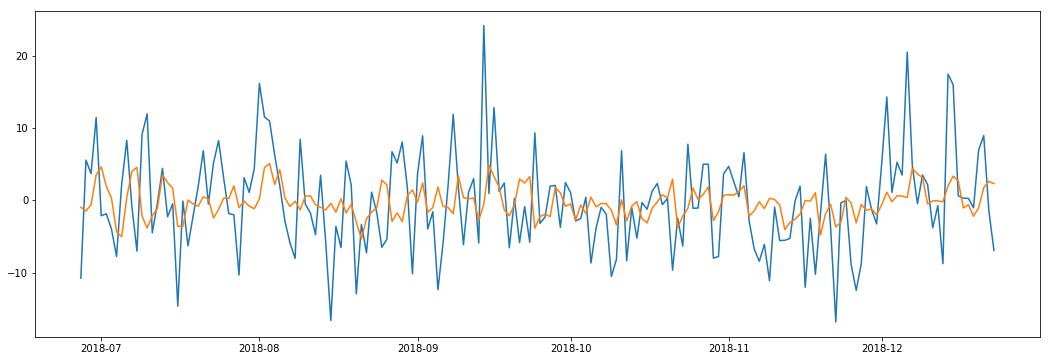

In [52]:
plt.figure(figsize=(18, 6))
plt.plot(d.test_date, d.Y_test, label='Actual')
plt.plot(d.test_date, test_pred, label='pred')
plt.show()

##### Plotting

In [31]:
district = city_crime.districts[1]
# district.keep_top_models(3)
for m in district.district_models:
    print("Model: {}".format(m.name))
    print("- MSE: {}".format(m.best_mse), "- Past Days: {}".format(m.best_feature))
    try:
        print(m.features[m.best_feature]['features'])
        print(m.features[m.best_feature]['feature_importance'])
    except KeyError:
        print("KeyError")
    print()

Model: Linear - Each Holiday w/ Dates Movie
- MSE: 51.86172839506172 - Past Days: 9
Index(['1DaysAgo', '2DaysAgo', '3DaysAgo', '4DaysAgo', '5DaysAgo', '6DaysAgo',
       '7DaysAgo', '8DaysAgo', '9DaysAgo', 'Holiday_BlackFriday',
       'Holiday_Christmas', 'Holiday_Father's Day', 'Holiday_Halloween',
       'Holiday_July4th', 'Holiday_LaborDay', 'Holiday_Lollapalooza',
       'Holiday_MemorialDay', 'Holiday_Mother's day', 'Holiday_NewYears',
       'Holiday_Presidents', 'Holiday_StPatricksDay', 'Holiday_Thanksgiving',
       'Holiday_VeteransDay', 'weekday', 'weekNumber', 'MovieCount'],
      dtype='object')
[ 1.22532679e+00  7.61349811e-01  2.26759405e-01  1.32043289e-01
 -6.27640851e-02  2.60595961e-01  2.14618978e-01  1.98372545e-01
 -1.75107697e-01  1.93834179e+00 -1.08078597e+01 -4.13261182e-03
  1.53544789e+00  1.50067105e+00  2.14419355e-01 -1.96496194e+00
  1.67538058e-01  1.33698201e+00  1.84892881e+01 -5.06129217e+00
 -1.53943512e+00 -6.57242938e-01 -1.45380959e+00 -1.3463463

In [21]:
district = city_crime.districts[-2]
for m in district.district_models:
    print("Model: {}".format(m.name))
    print("- MSE: {}".format(m.best_mse), "- Past Days: {}".format(m.best_feature))
    #try:
    #    print(m.features[m.best_feature]['features'])
    #except KeyError:
    #    print("KeyError")
    #print()

Model: Linear - Past Days only
- MSE: 19.918345679012347 - Past Days: 6
Model: Simplest Model
- MSE: 19.866123456790124 - Past Days: None
Model: Linear - Is Holiday
- MSE: 19.775012345679013 - Past Days: 3
Model: Linear - Is Holiday W/ Movie
- MSE: 19.69204938271605 - Past Days: 3
Model: Linear - Is Holiday w/ Dates
- MSE: 19.41612345679012 - Past Days: 4
Model: Linear - Is Holiday w/ Dates Movie
- MSE: 19.337234567901234 - Past Days: 2
Model: Linear - Each Holiday
- MSE: 21.229086419753088 - Past Days: 6
Model: Linear - Each Holiday w/ Movie
- MSE: 21.37575308641975 - Past Days: 6
Model: Linear - Each Holiday w/ Dates
- MSE: 21.185382716049386 - Past Days: 5
Model: Linear - Each Holiday w/ Dates Movie
- MSE: 21.238345679012347 - Past Days: 7
Model: Linear - Is Holiday w/ Past
- MSE: 19.697604938271606 - Past Days: 3
Model: Linear - Is Holiday w/ Movie Past
- MSE: 19.623901234567903 - Past Days: 3
Model: Linear - Is Holiday w/ Dates Past
- MSE: 19.25501234567901 - Past Days: 5
Model: L

In [41]:
best_models = list()
for district in city_crime.districts:
    model_names, model_mse, model_pred, model_features = district.model_report()
    model_rank = sorted([(n, m, f, p) for n, m, f, p in zip(model_names, model_mse, model_features, model_pred)], key=lambda x: x[1])
    print(district.name)
    print(model_names, model_mse)


District11
['SVR - Is Holiday w/ Dates'] [69.81388888888888]
District7
['Linear - Each Holiday w/ Dates Movie'] [51.86172839506172]
District2
['Linear - Each Holiday w/ Past'] [42.48346913580247]
District9
['Linear - Is Holiday w/ Dates Movie'] [37.675185185185185]
District5
['SVR - Each Holiday w/ Dates Past'] [33.26866049382716]
District6
['Linear - Is Holiday w/ Dates Movie'] [63.405648148148146]
District4
['Linear - Is Holiday w/ Dates Movie Past'] [47.5209012345679]
District12
['Linear - Is Holiday w/ Dates'] [49.77564814814815]
District15
['Linear - Is Holiday w/ Dates'] [27.513141975308645]
District14
['SVR - Each Holiday w/ Dates Past'] [30.804604938271606]
District20
['Linear - Each Holiday w/ Dates Past'] [23.703820987654318]
District10
['Linear - Each Holiday w/ Dates Movie'] [53.33167901234568]
District22
['SVR - Is Holiday w/ Dates Movie'] [25.026851851851852]
District8
['Linear - Each Holiday w/ Dates Past'] [55.28445679012346]
District17
['SVR - Each Holiday w/ Past'] [2

In [16]:
best_models = list()
for district in city_crime.districts:
    model_names, model_mse, model_pred, model_features = district.model_report()
    model_rank = sorted([(n, m, f, p) for n, m, f, p in zip(model_names, model_mse, model_features, model_pred)], key=lambda x: x[1])
    print(district.name)
    print("- Model: {} - mse: {}".format(model_rank[0][0], model_rank[0][1]), max(model_mse))
#    print("- Model: {} - mse: {}".format(model_rank[1][0], model_rank[1][1]), max(model_mse))
#    print("- Model: {} - mse: {}".format(model_rank[2][0], model_rank[2][1]), max(model_mse))
    best_models.append([district.name, model_rank[0]])    
#    print(len(district.district_models))
    #district.keep_top_models(1)

District11
- Model: SVR - Is Holiday w/ Dates Movie Past Weather - mse: 69.16981481481481 78.12203703703705
District7
- Model: Linear - Each Holiday w/ Dates Movie - mse: 51.86172839506172 58.162098765432106
District2
- Model: Linear - Each Holiday w/ Past - mse: 42.48346913580247 48.973839506172844
District9
- Model: SVR - Is Holiday w/ Dates Weather - mse: 37.63370370370371 39.8225925925926
District5
- Model: SVR - Each Holiday w/ Dates Past - mse: 33.26866049382716 36.12866049382716
District6
- Model: Linear - Is Holiday w/ Dates Movie - mse: 63.405648148148146 72.17194444444445
District4
- Model: Linear - Is Holiday w/ Dates Movie Past - mse: 47.5209012345679 51.84460493827161
District12
- Model: SVR - Is Holiday w/ Dates Weather - mse: 48.767870370370375 52.21268518518518
District15
- Model: Linear - Is Holiday w/ Dates Movie Past Weather - mse: 27.436845679012347 29.636845679012346
District14
- Model: SVR - Each Holiday w/ Dates Past - mse: 30.804604938271606 32.4109012345679
Dis

In [50]:
np.sum([x[1][1] for x in best_models])

946.5757962962963

In [90]:
np.sum([x[1][1] for x in best_models])

946.4272777777778

In [64]:
test_days = 180
city_features = []
city_data = []
for district in city_crime.districts:
    top_model = district.district_models[0]
    district_info = {'NormalizedDate': district.test_date,
             'District': [district.name]*len(district.test_date),
             'CrimeActual': district.daily_crime[-test_days:]}
    if top_model.best_feature is not None:
        district_info['CrimePred'] = [round(p + t, 0) for p, t in zip(top_model.features[top_model.best_feature]['test_prediction'],
                                                                district.day_average[-test_days:])]
        district_features = [(k, v) for k, v in zip(top_model.features[top_model.best_feature]['features'],
                                          top_model.features[top_model.best_feature]['feature_importance'])]
    else:
        district_info['CrimePred'] = [p + t for p, t in zip(top_model.features['test_prediction'],
                                                        district.day_average[-test_days:])]
        district_features = [('feature', top_model.features['feature_importance'])]
    # Add Error Values
    district_info['AbsoluteError'] = [a-p for p, a in zip(district_info['CrimePred'], district.daily_crime[-test_days:])]
    district_info['RelativeError'] = [(a-p)/a if a != 0 else 0 for p, a in zip(district_info['CrimePred'],
                                                                       district.daily_crime[-test_days:])]
    # Add Column indicting if the value is an anamoly
    anoms = set_anomalies(district_info['AbsoluteError'])
    district_info['AbsoluteAnom'] = [1 if i in anoms else 0 for i in range(len(district.Y_test))]
    anoms = set_anomalies(district_info['RelativeError'])
    district_info['RelativeAnom'] = [1 if i in anoms else 0 for i in range(len(district.Y_test))]
    city_data.append(pd.DataFrame(district_info))
    city_features.append([district.name, district_features])

In [68]:
city_data[10].AbsoluteAnom.sum()

3

In [69]:
city_data2 = pd.concat(city_data, ignore_index=True, axis=0)

In [73]:
city_data2.head()

NormalizedDate    District  CrimeActual  CrimePred  AbsoluteError  \
0     2018-06-27  District11           66       57.0            9.0   
1     2018-06-28  District11           50       59.0           -9.0   
2     2018-06-29  District11           60       57.0            3.0   
3     2018-06-30  District11           69       59.0           10.0   
4     2018-07-01  District11           76       59.0           17.0   

   RelativeError  AbsoluteAnom  RelativeAnom  
0       0.136364             0             0  
1      -0.180000             0             0  
2       0.050000             0             0  
3       0.144928             0             0  
4       0.223684             0             0

In [74]:
city_features

[['District11',
  [('1DaysAgo', 0.7294275967410788),
   ('2DaysAgo', -0.24843745845082846),
   ('3DaysAgo', 0.7793314322209023),
   ('4DaysAgo', 0.033747456376576265),
   ('5DaysAgo', -0.007603841180103997),
   ('6DaysAgo', 0.06810669110550763),
   ('7DaysAgo', 0.18665376299160516),
   ('8DaysAgo', -0.17451469457847105),
   ('9DaysAgo', -0.0488378215619998),
   ('10DaysAgo', 0.0191270994166836),
   ('11DaysAgo', -0.1367891896833582),
   ('12DaysAgo', -0.007346077546411713),
   ('13DaysAgo', 0.1483442896879975),
   ('14DaysAgo', 0.01802937107508784),
   ('15DaysAgo', 0.09394144372743544),
   ('16DaysAgo', -0.542777294229272),
   ('17DaysAgo', -0.32940712370081976),
   ('18DaysAgo', -0.19639357868059013),
   ('19DaysAgo', 0.10474224956894661),
   ('20DaysAgo', -0.040534259393266776),
   ('21DaysAgo', -0.004508935250807343),
   ('22DaysAgo', -0.4226532688982304),
   ('23DaysAgo', -0.4281768361767051),
   ('24DaysAgo', -0.0721411861493559),
   ('25DaysAgo', -0.21020424681721492),
   ('26Da

In [102]:
with open('BokehData.pkl', 'rb') as handle:
    best_pred, the_features = pickle.load(handle)

In [103]:
best_pred.head(3)

AbsoluteAnom  AbsoluteError  CrimeActual  CrimePred    District  \
0             0            9.0           66       57.0  District11   
1             0           -9.0           50       59.0  District11   
2             0            3.0           60       57.0  District11   

  NormalizedDate  RelativeAnom  RelativeError  DistrictNum  
0     2018-06-27             0       0.136364           11  
1     2018-06-28             0      -0.180000           11  
2     2018-06-29             0       0.050000           11

In [35]:
blended = [np.mean([i, j]) for i, j in zip(model_pred[12], model_pred[13])]
blended_mse = mean_squared_error(district.Y_test, blended)
blended_mse

In [24]:
district = city_crime.districts[-2]
print(district.district_models[-1].best_feature)
district.district_models[-1].features[2]['test_prediction']

2


[-7.0,
 5.0,
 -8.0,
 -8.0,
 7.0,
 -6.0,
 -1.0,
 -3.0,
 -7.0,
 0.0,
 -5.0,
 -6.0,
 4.0,
 -3.0,
 -6.0,
 -3.0,
 -6.0,
 6.0,
 -8.0,
 -6.0,
 -2.0,
 -3.0,
 2.0,
 -8.0,
 -3.0,
 -8.0,
 -5.0,
 10.0,
 -7.0,
 5.0,
 -3.0,
 3.0,
 -7.0,
 4.0,
 -3.0,
 -2.0,
 1.0,
 1.0,
 1.0,
 -5.0,
 11.0,
 -5.0,
 8.0,
 2.0,
 -3.0,
 4.0,
 0.0,
 -3.0,
 -2.0,
 -4.0,
 0.0,
 2.0,
 -8.0,
 -7.0,
 4.0,
 -2.0,
 -7.0,
 -2.0,
 8.0,
 2.0,
 4.0,
 -3.0,
 -11.0,
 -2.0,
 -1.0,
 -7.0,
 -5.0,
 -7.0,
 -9.0,
 -0.0,
 -7.0,
 -2.0,
 -2.0,
 2.0,
 -2.0,
 -2.0,
 -4.0,
 -4.0,
 -6.0,
 -2.0,
 -3.0,
 -7.0,
 -4.0,
 -11.0,
 -4.0,
 1.0,
 -7.0,
 -2.0,
 -3.0,
 -6.0,
 -1.0,
 -6.0,
 -5.0,
 -7.0,
 -3.0,
 -4.0,
 -0.0,
 -4.0,
 -1.0,
 -5.0,
 -1.0,
 5.0,
 -4.0,
 -2.0,
 -2.0,
 -3.0,
 7.0,
 -3.0,
 -2.0,
 -8.0,
 -0.0,
 0.0,
 -4.0,
 8.0,
 2.0,
 1.0,
 5.0,
 -9.0,
 -5.0,
 0.0,
 8.0,
 0.0,
 1.0,
 -3.0,
 -4.0,
 -3.0,
 5.0,
 1.0,
 1.0,
 -9.0,
 -9.0,
 -9.0,
 -5.0,
 0.0,
 1.0,
 1.0,
 -6.0,
 -7.0,
 1.0,
 1.0,
 -2.0,
 11.0,
 -4.0,
 6.0,
 -8.0,
 1.0,
 -1.0,
 -4.0,
 3.0,
 

C:\Users\Jenn\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


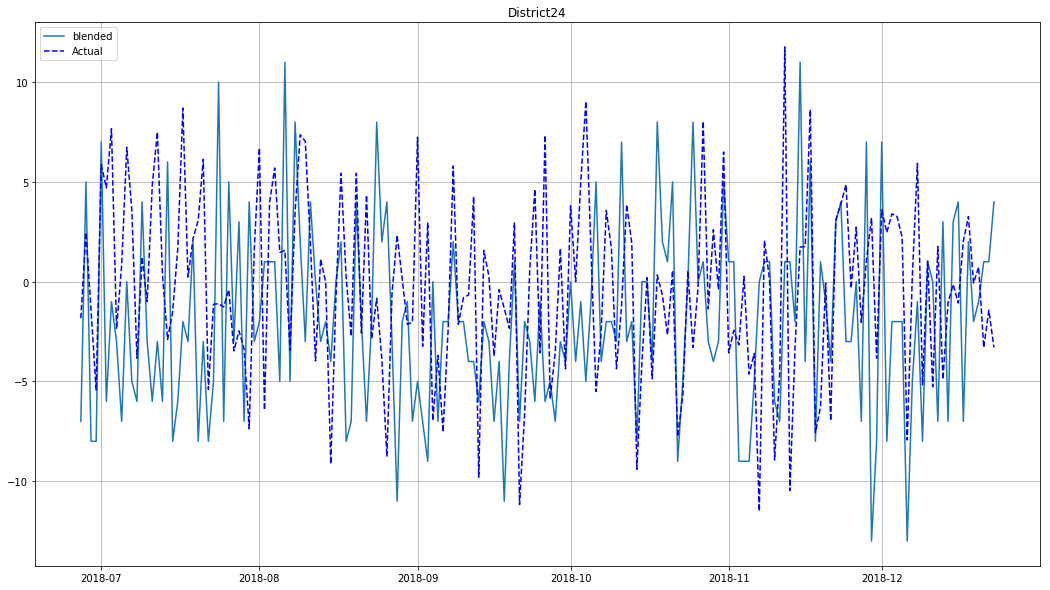

In [25]:
plt.figure(figsize=(18,10))
plt.title(district.name)
#for i in range(len(model_pred[0:2])):
#    plt.plot(district.test_date, model_pred[i], label=model_names[i], alpha=0.5)
#plt.plot(district.train_date[-180:], district.Y_train[-180:])
plt.plot(district.test_date, district.district_models[-1].features[2]['test_prediction'], label='blended')
plt.plot(district.test_date, district.Y_test, label='Actual', linestyle="--", c="blue")
plt.legend(loc="upper left")
plt.grid()
plt.show()
    

In [34]:
def locate_anomalies(my_series, g_threshold, l_threshold):
    items_greater = [i for i in range(len(my_series)) if my_series[i] > g_threshold]
    items_less = [i for i in range(len(my_series)) if my_series[i] < l_threshold]
    return set(items_greater + items_less)

def set_anomalies(values):
    iteration = 0
    mean = np.mean(values)
    std = np.std(values)
    g_threshold = mean + 3 * std
    l_threshold = mean - 3 * std
    anoms = locate_anomalies(values, g_threshold, l_threshold)
    prev_anoms = set()
    anom_iteration = list()
    while len(anoms) > len(prev_anoms):
        anom_iteration.append(anoms)
        prev_anoms = anoms
        iteration += 1
        new_values = [v for i, v in enumerate(values) if i not in anoms]
        mean = np.mean(new_values)
        std = np.std(new_values)
        g_threshold = mean + 3 * std
        l_threshold = mean - 3 * std
        anoms = locate_anomalies(values, g_threshold, l_threshold)
    return anoms

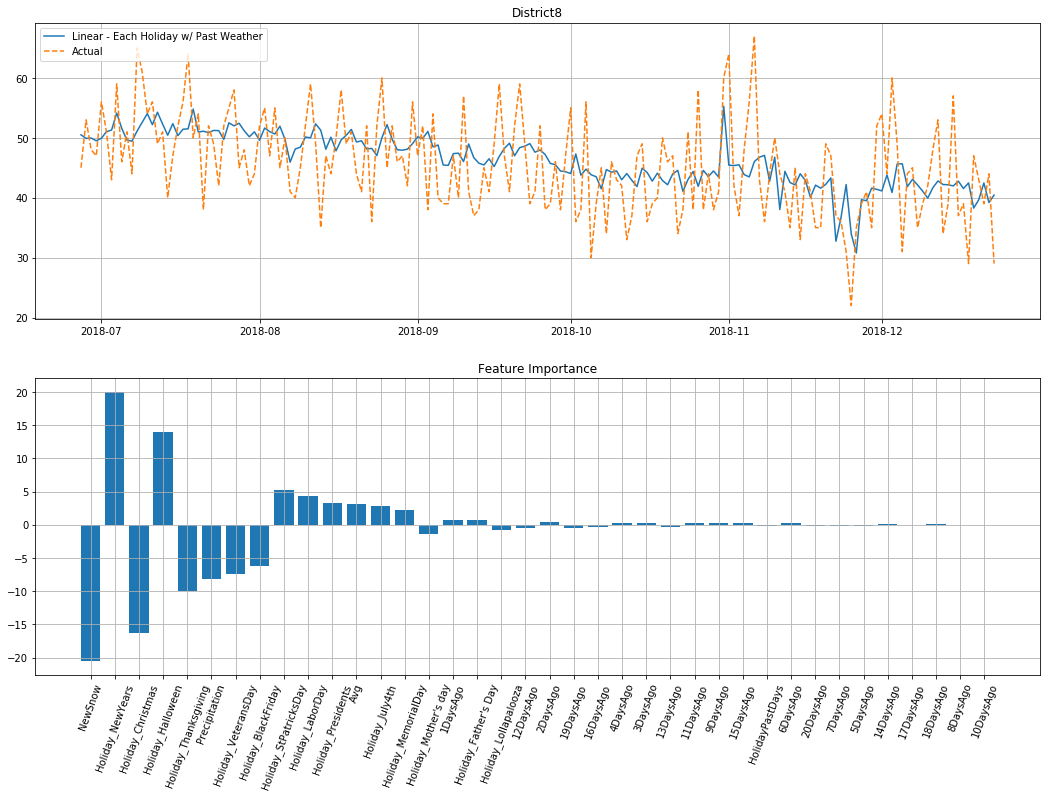

In [38]:
district_ind = 13

plt.figure(figsize=(18,12))
plt.subplot(2, 1, 1)
plt.title(best_models[district_ind][0])
re_trended = [p + t for p, t in zip(best_models[district_ind][1][3], city_crime.districts[district_ind].day_average[-180:])]
plt.plot(district.test_date, re_trended,
         label=best_models[district_ind][1][0])
plt.plot(district.test_date, city_crime.districts[district_ind].daily_crime[-180:], label='Actual', linestyle="--")
plt.legend(loc="upper left")
plt.grid()
plt.subplot(2, 1, 2)
plt.title("Feature Importance")
fea_val = sorted(best_models[district_ind][1][2], key=lambda x: abs(x[1]), reverse=True)
plt.bar(range(len(fea_val)), [x[1] for x in fea_val])
plt.xticks(range(len(fea_val)), [x[0] for x in fea_val], rotation=70)
plt.grid()
plt.show()

    

In [95]:
len(city_crime.districts[-3].detrended), len(best_models[district_ind][1][3])

(1423, 180)

C:\Users\Jenn\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


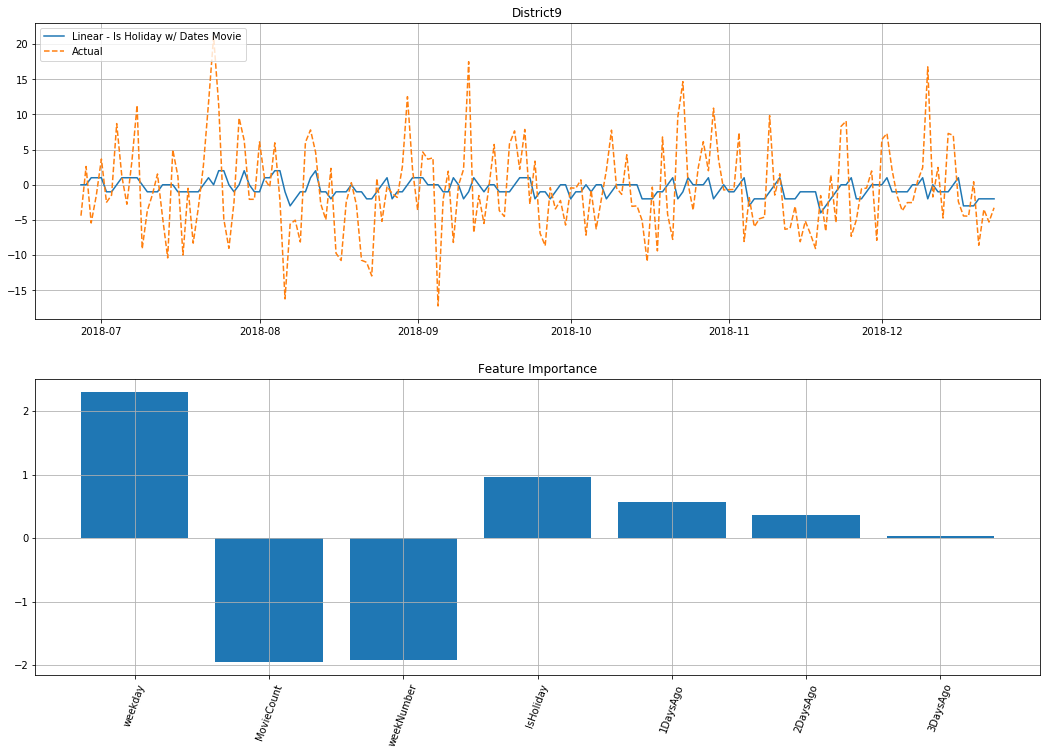

In [44]:
district_ind = 3

plt.figure(figsize=(18,12))
plt.subplot(2, 1, 1)
plt.title(best_models[district_ind][0])
plt.plot(district.test_date, best_models[district_ind][1][3], label=best_models[district_ind][1][0])
plt.plot(district.test_date, city_crime.districts[district_ind].Y_test, label='Actual', linestyle="--")
plt.legend(loc="upper left")
plt.grid()
plt.subplot(2, 1, 2)
plt.title("Feature Importance")
fea_val = sorted(best_models[district_ind][1][2], key=lambda x: abs(x[1]), reverse=True)
plt.bar(range(len(fea_val)), [x[1] for x in fea_val])
plt.xticks(range(len(fea_val)), [x[0] for x in fea_val], rotation=70)
plt.grid()
plt.show()

    

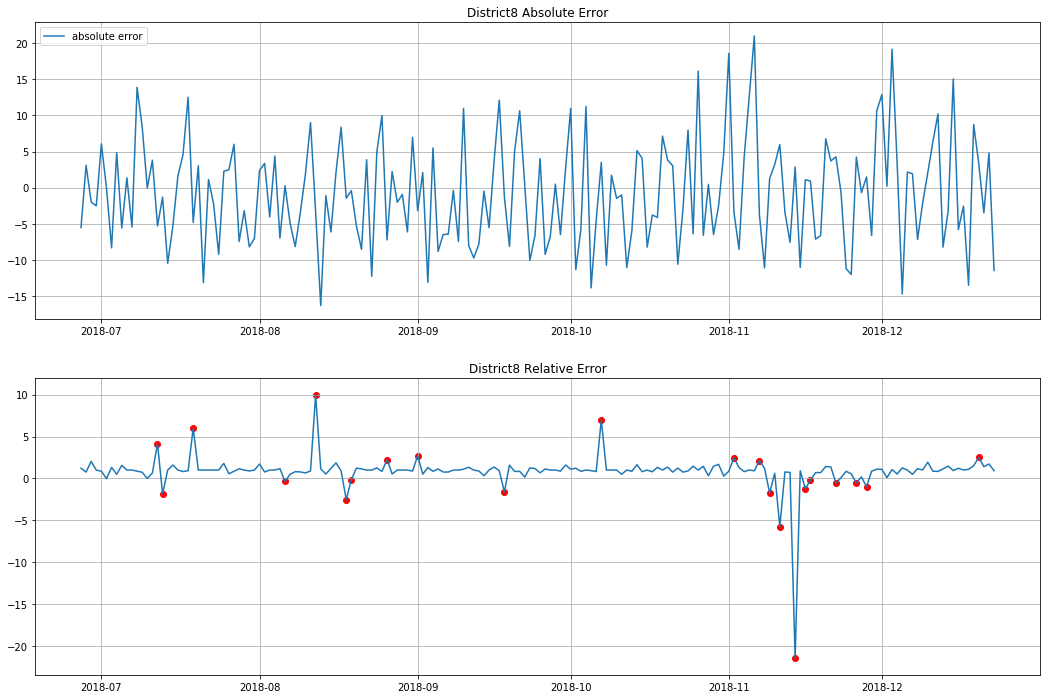

In [39]:
# district_ind = 13

abs_error = [a-p for p, a in zip(best_models[district_ind][1][3], city_crime.districts[district_ind].Y_test)]
rel_error = [(a-p)/a if a != 0 else 0 for p, a in zip(best_models[district_ind][1][3], city_crime.districts[district_ind].Y_test)]
anoms = set_anomalies(rel_error)
plt.figure(figsize=(18,12))
plt.subplot(2, 1, 1)
plt.title(best_models[district_ind][0] + ' Absolute Error')
plt.plot(district.test_date, abs_error, label='absolute error')
a_anoms = set_anomalies(abs_error)
plt.scatter([d for i, d in enumerate(district.test_date) if i in a_anoms],
             [v for i, v in enumerate(abs_error) if i in a_anoms], c='red')
plt.legend(loc="upper left")
plt.grid()
plt.subplot(2, 1, 2)
plt.title(best_models[district_ind][0] + " Relative Error")
r_anoms = set_anomalies(rel_error)
plt.plot(district.test_date, rel_error, label='relative error')
plt.scatter([d for i, d in enumerate(district.test_date) if i in r_anoms],
             [v for i, v in enumerate(rel_error) if i in r_anoms], c='red')
plt.grid()
plt.show()

    

In [40]:
[d for i, d in enumerate(district.test_date) if i in r_anoms]

[Timestamp('2018-07-12 00:00:00'),
 Timestamp('2018-07-13 00:00:00'),
 Timestamp('2018-07-19 00:00:00'),
 Timestamp('2018-08-06 00:00:00'),
 Timestamp('2018-08-12 00:00:00'),
 Timestamp('2018-08-18 00:00:00'),
 Timestamp('2018-08-19 00:00:00'),
 Timestamp('2018-08-26 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-09-18 00:00:00'),
 Timestamp('2018-10-07 00:00:00'),
 Timestamp('2018-11-02 00:00:00'),
 Timestamp('2018-11-07 00:00:00'),
 Timestamp('2018-11-09 00:00:00'),
 Timestamp('2018-11-11 00:00:00'),
 Timestamp('2018-11-14 00:00:00'),
 Timestamp('2018-11-16 00:00:00'),
 Timestamp('2018-11-17 00:00:00'),
 Timestamp('2018-11-22 00:00:00'),
 Timestamp('2018-11-26 00:00:00'),
 Timestamp('2018-11-28 00:00:00'),
 Timestamp('2018-12-20 00:00:00')]

In [60]:
d_anoms = []
for i in range(len(city_crime.districts)):
    rel_error = [(a-p)/a if a != 0 else 0 for p, a in zip(best_models[i][1][3], city_crime.districts[i].Y_test)]
    anoms = set_anomalies(rel_error)
    d_anom = [(d, v) for d, v, i in zip(city_crime.districts[i].test_date, rel_error, range(len(rel_error))) if i in anoms]
    d_anoms += d_anom

In [61]:
import collections

In [62]:
dist_anoms = collections.defaultdict(lambda: collections.defaultdict(int))
for a in d_anoms:
    dist_anoms[a[0]]['count'] += 1
    dist_anoms[a[0]]['value'] += abs(a[1])

In [63]:
common = sorted([(k, v['count'], v['value']) for k, v in dist_anoms.items()], key=lambda x: x[1], reverse=True)
common[0:10]

[(Timestamp('2018-08-05 00:00:00'), 10, 13.264472514777578),
 (Timestamp('2018-11-28 00:00:00'), 8, 37.747956848643454),
 (Timestamp('2018-11-11 00:00:00'), 8, 23.780216461117973),
 (Timestamp('2018-12-22 00:00:00'), 8, 21.17159468438547),
 (Timestamp('2018-09-10 00:00:00'), 8, 71.35872793268223),
 (Timestamp('2018-10-24 00:00:00'), 7, 17.989978114657877),
 (Timestamp('2018-10-19 00:00:00'), 7, 36.428571428571324),
 (Timestamp('2018-11-23 00:00:00'), 7, 48.97325387293253),
 (Timestamp('2018-07-04 00:00:00'), 7, 28.710568723517174),
 (Timestamp('2018-11-16 00:00:00'), 7, 51.347660613617876)]

In [64]:
common = sorted([(k, v['count'], v['value']) for k, v in dist_anoms.items()], key=lambda x: x[2], reverse=True)
common[0:10]

[(Timestamp('2018-12-20 00:00:00'), 3, 213.1136363636483),
 (Timestamp('2018-07-24 00:00:00'), 5, 161.70583887657912),
 (Timestamp('2018-11-24 00:00:00'), 3, 99.87912087911637),
 (Timestamp('2018-09-10 00:00:00'), 8, 71.35872793268223),
 (Timestamp('2018-11-16 00:00:00'), 7, 51.347660613617876),
 (Timestamp('2018-08-06 00:00:00'), 6, 50.35314581989944),
 (Timestamp('2018-11-23 00:00:00'), 7, 48.97325387293253),
 (Timestamp('2018-09-30 00:00:00'), 4, 48.71515151514927),
 (Timestamp('2018-11-14 00:00:00'), 6, 43.234532102953295),
 (Timestamp('2018-08-14 00:00:00'), 4, 41.26470588235131)]

#### Weather

In [22]:
weather_df = pd.read_csv(r'..\WeatherData.csv', parse_dates=['Date'])
weather_df['Precipitation'] = weather_df.Precipitation.fillna(0)
weather_df['NewSnow'] = weather_df.NewSnow.fillna(0)

In [24]:
weather_df.iloc[180:190,:]

Date  MaxTemp  MinTemp   Avg Departure  HDD  CDD  Precipitation  \
180 2015-06-30       77       57  67.0        -6    0    2           0.17   
181 2015-07-01       69       54  61.5     -11.7    3    0           0.00   
182 2015-07-02       69       53  61.0     -12.3    4    0           0.00   
183 2015-07-03       77       55  66.0      -7.5    0    1           0.00   
184 2015-07-04       81       59  70.0      -3.6    0    5           0.00   
185 2015-07-05       83       60  71.5      -2.2    0    7           0.00   
186 2015-07-06       85       64  74.5       0.7    0   10           0.49   
187 2015-07-07       71       55  63.0     -10.9    2    0           0.27   
188 2015-07-08       67       54  60.5     -13.5    4    0           0.07   
189 2015-07-09       77       58  67.5      -6.6    0    3           0.00   

     NewSnow  SnowDepth  
180      0.0        0.0  
181      0.0        0.0  
182      0.0        0.0  
183      0.0        0.0  
184      0.0        0.0  
185      0.0        0.0  
186      0.0        0.0  
187      0.0        0.0  
188      0.0        0.0  
189      0.0        0.0

In [19]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 10 columns):
Date             1506 non-null datetime64[ns]
MaxTemp          1506 non-null int64
MinTemp          1506 non-null int64
Avg              1506 non-null float64
Departure        1506 non-null object
HDD              1506 non-null int64
CDD              1506 non-null int64
Precipitation    1268 non-null float64
NewSnow          1394 non-null float64
SnowDepth        1505 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(4), object(1)
memory usage: 117.7+ KB


In [26]:
weather_df.Avg.min(), weather_df.Avg.max()

(-16.5, 87.0)

In [25]:
days_of_crime = 30
# Loop through each district created
for district in city_crime.districts:
    # Detrend for 30 days, past 30 days as features, last 180 days in test
    district.n_day_average(30)
    district.generate_features(days_of_crime)
    district.split_data(180)
    reg = LinearRegression()
    district_model = DistrictModel('Linear-Past Days only', reg, 'Linear', district.X_train,
                                                         district.Y_train, district.X_test, district.Y_test,
                                                         days_of_crime, 0)
    district_model.generate_linear_models()
    district.district_models.append(district_model)
    print("Name: {} - MSE: {}".format(district.name, district_model.best_mse))

Name: District11 - MSE: 73.5791392739367
Name: District7 - MSE: 52.85827013326624
Name: District2 - MSE: 47.398417347309206
Name: District9 - MSE: 38.63168910965666
Name: District5 - MSE: 34.3512481944652
Name: District6 - MSE: 66.21731204875226
Name: District4 - MSE: 48.7090093783527
Name: District12 - MSE: 51.143676541937644
Name: District15 - MSE: 28.01556279661059
Name: District14 - MSE: 32.05112632397274
Name: District20 - MSE: 24.58525983375372
Name: District10 - MSE: 55.64199987081591
Name: District22 - MSE: 26.052100476398632
Name: District8 - MSE: 57.4097957705974
Name: District17 - MSE: 24.367881540676354
Name: District3 - MSE: 42.1540870050917
Name: District18 - MSE: 84.27577299567585
Name: District16 - MSE: 28.13831320695889
Name: District25 - MSE: 48.17957063586584
Name: District1 - MSE: 84.11270245929258
Name: District24 - MSE: 19.90806606167917
Name: District19 - MSE: 44.416826070128806


In [26]:
import pickle

In [29]:
sample_df, f = pickle.load(open("BokehData.pkl", 'rb'))

In [30]:
sample_df.head()

AbsoluteAnom  AbsoluteError  CrimeActual  CrimePred    District  \
0             0            9.0           66       57.0  District11   
1             0           -9.0           50       59.0  District11   
2             0            3.0           60       57.0  District11   
3             0           10.0           69       59.0  District11   
4             0           17.0           76       59.0  District11   

  NormalizedDate  RelativeAnom  RelativeError  DistrictNum  
0     2018-06-27             0       0.136364           11  
1     2018-06-28             0      -0.180000           11  
2     2018-06-29             0       0.050000           11  
3     2018-06-30             0       0.144928           11  
4     2018-07-01             0       0.223684           11

In [23]:
import pandas as pd
import numpy as np
import pickle
import datetime as dt
import sqlite3


BEST_FILE = r'BokehData.pkl'
SQL_FILE = r'..\RefreshChicagoCrime.sqlite'
DATE_COLS = ['Date', 'UpdatedOn', 'NormalizedDate']


def load_data(sql_file=SQL_FILE, date_cols=DATE_COLS):
    with sqlite3.connect(sql_file) as con:
        df = pd.read_sql_query(
            """ SELECT * from chicagoCrime where CAST(strftime('%Y', NormalizedDate) as INTEGER) >= 2015""",
            con, parse_dates=date_cols)
    return df


In [26]:
new_df = load_data()

In [27]:
new_df.NormalizedDate.max()

Timestamp('2019-02-08 00:00:00')